# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Load the dataset


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [4]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [5]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## CUSTOM

Switching discrete value labeled as int to str

In [7]:
dataset_df['MSSubClass'] = dataset_df['MSSubClass'].astype(str)

Dropping Constant Features using VarianceThreshold

In [8]:
df_not_num = dataset_df.select_dtypes(exclude = ['float64', 'int64'])
df_not_num

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [9]:
# import ordinal encoder from sklearn
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
  
# Transform the data
dataset_df[df_not_num.columns] = ord_enc.fit_transform(dataset_df[df_not_num.columns])

In [10]:
from sklearn.feature_selection import VarianceThreshold

var_thr = VarianceThreshold(threshold = 0.25) #Removing both constant and quasi-constant
var_thr.fit(dataset_df)

var_thr.get_support()

array([ True,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True])

In [11]:
concol = [column for column in dataset_df.columns 
          if column not in dataset_df.columns[var_thr.get_support()]]

for features in concol:
    print(features)

Street
Alley
Utilities
LandSlope
Condition2
Heating
CentralAir
BsmtHalfBath
KitchenAbvGr
PavedDrive
MiscFeature


In [12]:
dataset_df.drop(concol,axis=1)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,9.0,3.0,65.0,8450,3.0,3.0,4.0,5.0,2.0,0.0,...,0,0,NaN,NaN,0,2,2008,8.0,4.0,208500
1,4.0,3.0,80.0,9600,3.0,3.0,2.0,24.0,1.0,0.0,...,0,0,NaN,NaN,0,5,2007,8.0,4.0,181500
2,9.0,3.0,68.0,11250,0.0,3.0,4.0,5.0,2.0,0.0,...,0,0,NaN,NaN,0,9,2008,8.0,4.0,223500
3,10.0,3.0,60.0,9550,0.0,3.0,0.0,6.0,2.0,0.0,...,0,0,NaN,NaN,0,2,2006,8.0,0.0,140000
4,9.0,3.0,84.0,14260,0.0,3.0,2.0,15.0,2.0,0.0,...,0,0,NaN,NaN,0,12,2008,8.0,4.0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,9.0,3.0,62.0,7917,3.0,3.0,4.0,8.0,2.0,0.0,...,0,0,NaN,NaN,0,8,2007,8.0,4.0,175000
1456,4.0,3.0,85.0,13175,3.0,3.0,4.0,14.0,2.0,0.0,...,0,0,NaN,2.0,0,2,2010,8.0,4.0,210000
1457,10.0,3.0,66.0,9042,3.0,3.0,4.0,6.0,2.0,0.0,...,0,0,NaN,0.0,2500,5,2010,8.0,4.0,266500
1458,4.0,3.0,68.0,9717,3.0,3.0,4.0,12.0,2.0,0.0,...,0,0,NaN,NaN,0,4,2010,8.0,4.0,142125


In [13]:
dataset_df[df_not_num.columns] = dataset_df[df_not_num.columns].astype(str)

## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


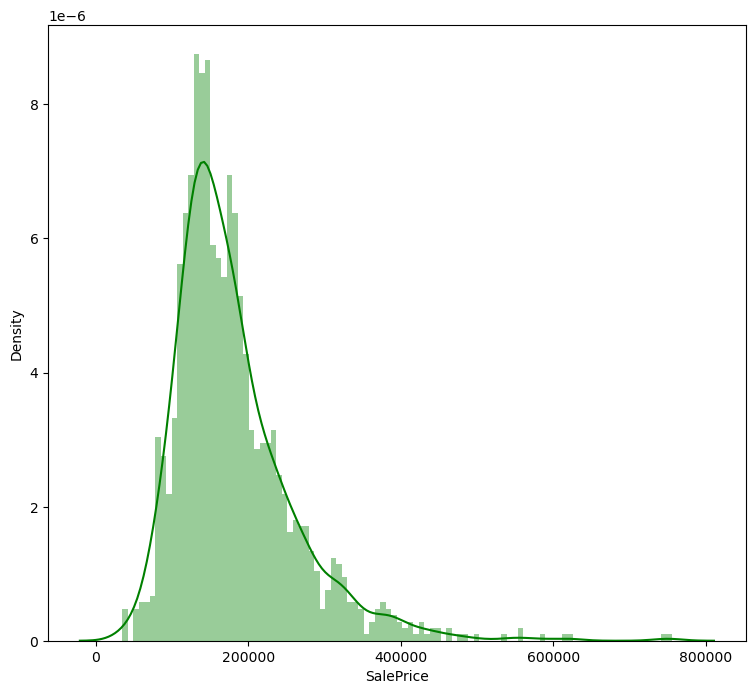

In [14]:
print(dataset_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [15]:
list(set(dataset_df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [16]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

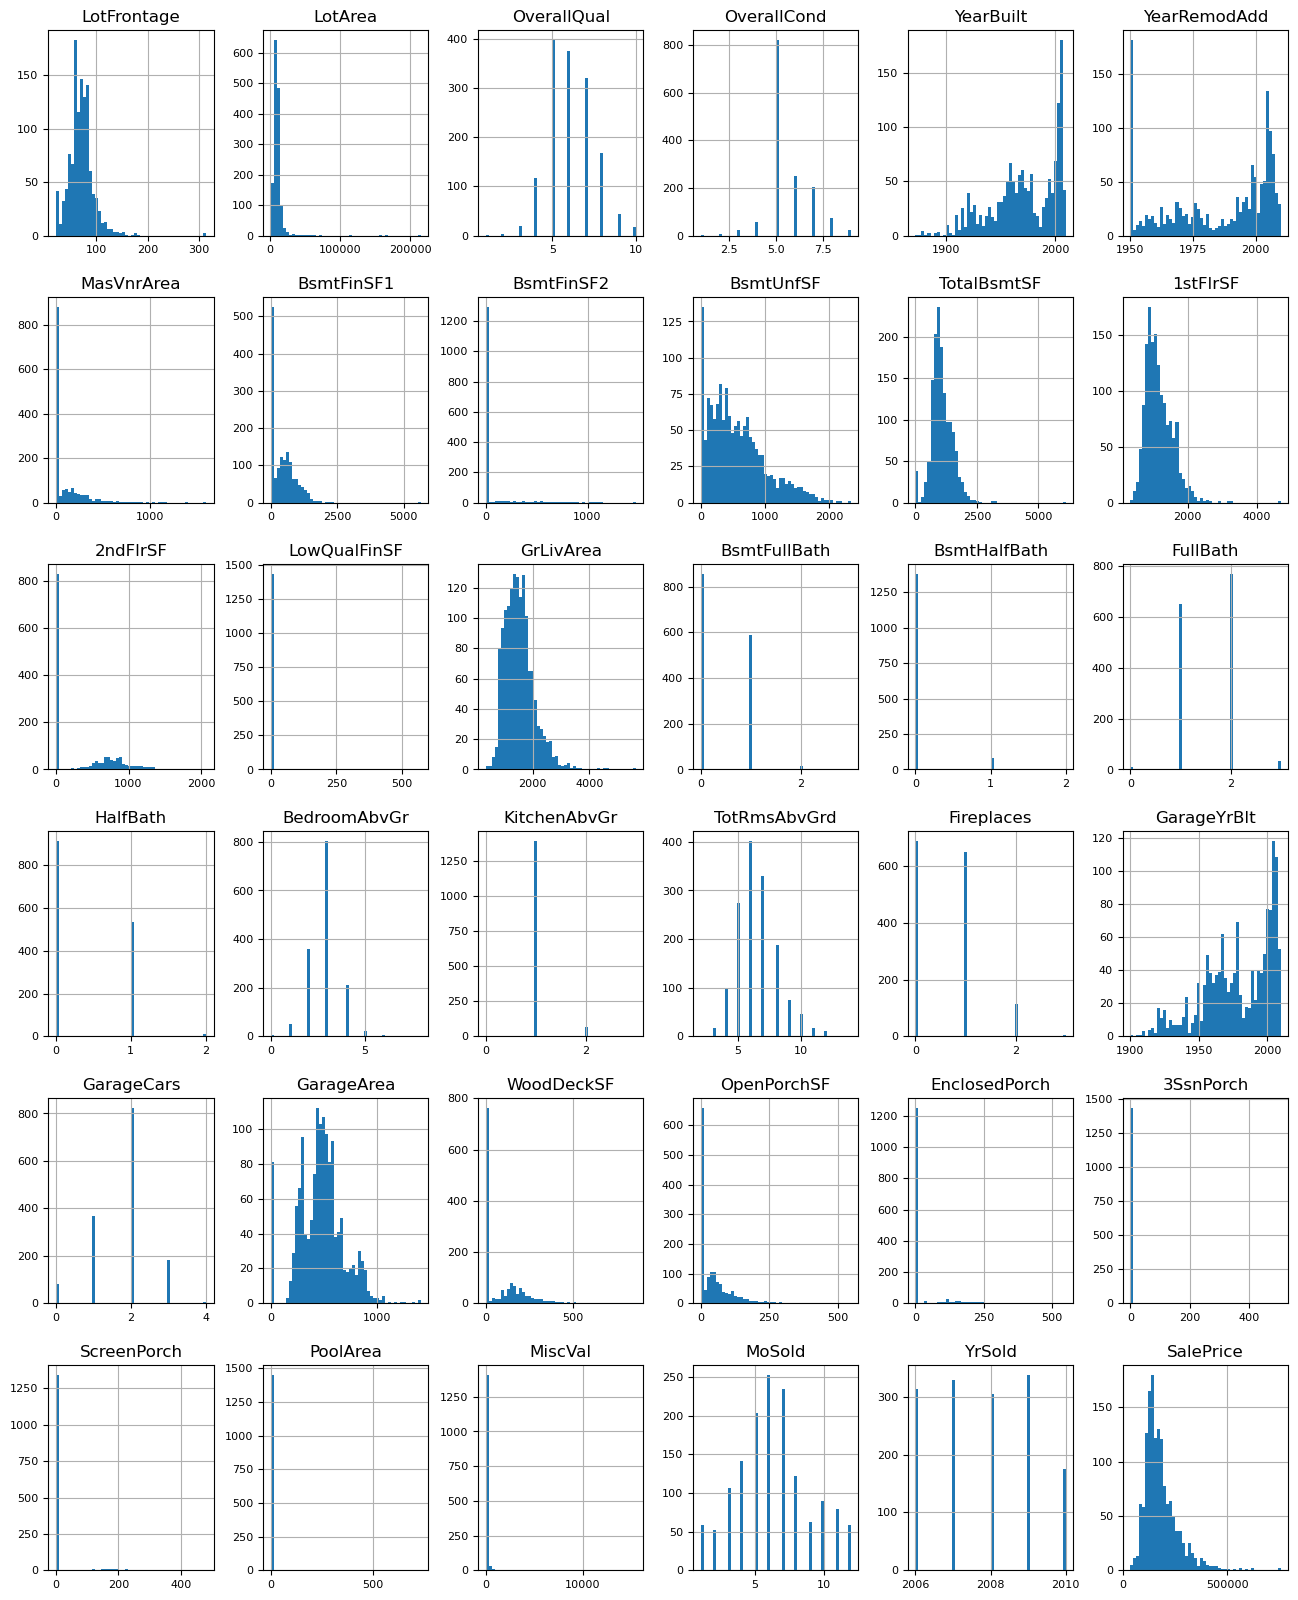

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [18]:
import numpy as np

def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1172 examples in training, 288 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [19]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [20]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [21]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmpj50w5uzz as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [22]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.166844. Found 1172 examples.
Training model...


[INFO 2023-05-03T08:40:56.722040919+00:00 kernel.cc:1214] Loading model from path /tmp/tmpj50w5uzz/model/ with prefix 62eea2e7407a4de7


Model trained in 0:00:02.497335
Compiling model...


[INFO 2023-05-03T08:40:57.179828484+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 111376 node(s), and 75 input feature(s).
[INFO 2023-05-03T08:40:57.179906999+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-05-03T08:40:57.17997413+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [23]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

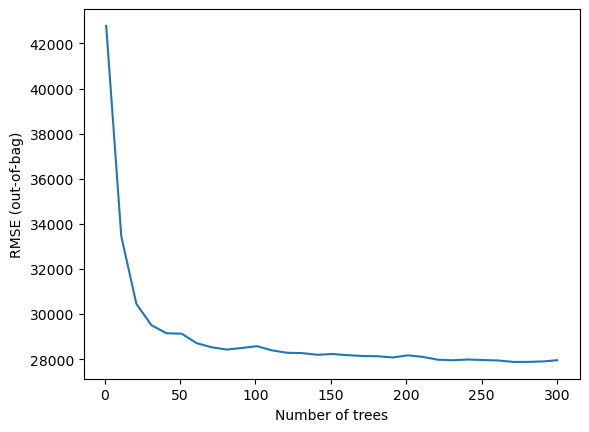

In [24]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [25]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1172, accuracy=None, loss=None, rmse=27955.244771313835, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [26]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 734ms/step - loss: 0.0000e+00 - mse: 1133432320.0000
loss: 0.0000
mse: 1133432320.0000


### CUSTOM
V1: 744014208.0000

V2: 700403776.0000

V3: 900519680.0000

V4: 854875392.0000

## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [27]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [28]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 108.0),
 ("ExterQual" (4; #22), 51.0),
 ("GarageCars" (1; #32), 51.0),
 ("Neighborhood" (4; #59), 33.0),
 ("GrLivArea" (1; #38), 20.0),
 ("KitchenQual" (4; #44), 10.0),
 ("TotalBsmtSF" (1; #73), 8.0),
 ("YearBuilt" (1; #76), 7.0),
 ("BsmtQual" (4; #14), 4.0),
 ("GarageArea" (1; #31), 4.0),
 ("1stFlrSF" (1; #0), 2.0),
 ("Fireplaces" (1; #27), 1.0),
 ("GarageYrBlt" (1; #37), 1.0)]

Plot the variable importances from the inspector using Matplotlib

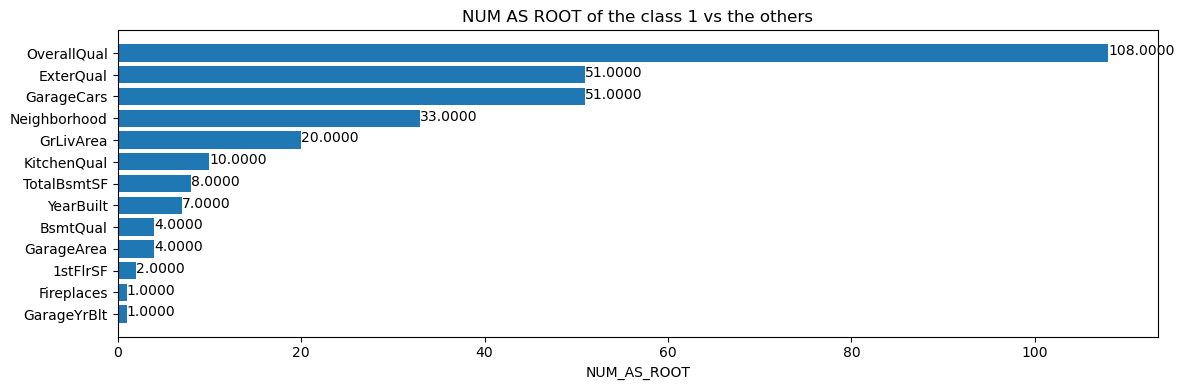

In [29]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [30]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')

In [31]:
## CUSTOM
test_data['MSSubClass'] = test_data['MSSubClass'].astype(str)
test_data[df_not_num.columns] = ord_enc.fit_transform(test_data[df_not_num.columns])
var_thr.fit(test_data)
test_data[df_not_num.columns] = test_data[df_not_num.columns].astype(str)
test_data.drop(concol,axis=1)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5.0,2.0,80.0,11622,3.0,3.0,4.0,12.0,1.0,0.0,...,0,120,0,nan,2.0,0,6,2010,8.0,4.0
1,5.0,3.0,81.0,14267,0.0,3.0,0.0,12.0,2.0,0.0,...,0,0,0,nan,nan,12500,6,2010,8.0,4.0
2,10.0,3.0,74.0,13830,0.0,3.0,4.0,8.0,2.0,0.0,...,0,0,0,nan,2.0,0,3,2010,8.0,4.0
3,10.0,3.0,78.0,9978,0.0,3.0,4.0,8.0,2.0,0.0,...,0,0,0,nan,nan,0,6,2010,8.0,4.0
4,0.0,3.0,43.0,5005,0.0,1.0,4.0,22.0,2.0,4.0,...,0,144,0,nan,nan,0,1,2010,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.0,4.0,21.0,1936,3.0,3.0,4.0,10.0,2.0,3.0,...,0,0,0,nan,nan,0,6,2006,8.0,4.0
1455,2.0,4.0,21.0,1894,3.0,3.0,4.0,10.0,2.0,4.0,...,0,0,0,nan,nan,0,4,2006,8.0,0.0
1456,5.0,3.0,160.0,20000,3.0,3.0,4.0,11.0,2.0,0.0,...,0,0,0,nan,nan,0,9,2006,8.0,0.0
1457,14.0,3.0,62.0,10441,3.0,3.0,4.0,11.0,2.0,0.0,...,0,0,0,nan,2.0,700,7,2006,8.0,4.0


In [32]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 26ms/step


,Id,SalePrice
0,1461,119521.828125
1,1462,142196.781250
2,1463,175216.734375
3,1464,180425.375000
4,1465,192954.218750


In [33]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 24ms/step


,Id,SalePrice
0,1461,119521.828125
1,1462,142196.781250
2,1463,175216.734375
3,1464,180425.375000
4,1465,192954.218750
